# ARC - Multi (many) Input Model Approach

This notebook is based on the `Abstraction and Reasoning Starter Notebook`

In [124]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [125]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/abstraction-and-reasoning-challenge
/kaggle/input/abstraction-and-reasoning-challenge/training
/kaggle/input/abstraction-and-reasoning-challenge/test
/kaggle/input/abstraction-and-reasoning-challenge/evaluation


I like to use the `Path` class for my paths.

In [126]:
from pathlib import Path

data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
output_path = Path('/kaggle/output/kaggle/working/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

The `training` folder has 400 JSON tasks. The names of the first three are shown below.

In [127]:
training_tasks = sorted(os.listdir(training_path))
print(training_tasks[:3])

['007bbfb7.json', '00d62c1b.json', '017c7c7b.json']


In each task, there are two dictionary keys, `train` and `test`. You learn the pattern from the train input-output pairs, and then apply the pattern to the `test` input, to predict an output.

In [128]:
task_file = str(training_path / '00d62c1b.json')

with open(task_file, 'r') as f:
    task = json.load(f)

print(task.keys())

dict_keys(['train', 'test'])


Tasks have multiple `train` input-output pairs. Most tasks have a single `test` input-output pair, although some have more than one.

In [129]:
n_train_pairs = len(task['train'])
n_test_pairs = len(task['test'])

print(f'task contains {n_train_pairs} training pairs')
print(f'task contains {n_test_pairs} test pairs')

task contains 5 training pairs
task contains 1 test pairs


Drilling into the first `train` input-output pair, we can see the grids are expressed as 2d lists with integers 0-9.

In [130]:
display(task['train'][0]['input'])
display(task['train'][0]['output'])

[[0, 0, 0, 0, 0, 0],
 [0, 0, 3, 0, 0, 0],
 [0, 3, 0, 3, 0, 0],
 [0, 0, 3, 0, 3, 0],
 [0, 0, 0, 3, 0, 0],
 [0, 0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0, 0],
 [0, 0, 3, 0, 0, 0],
 [0, 3, 4, 3, 0, 0],
 [0, 0, 3, 4, 3, 0],
 [0, 0, 0, 3, 0, 0],
 [0, 0, 0, 0, 0, 0]]

## Function to plot the first train/test input/output pairs of a task

You can use this function to plot the first `train` and `test` grids. The color aligns with what is found on the ARC app. Note though, the ARC app presents the grids to scale, where these display the grids in the same size, regardless of their dimension.

In [131]:
def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#8a6801'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 4, figsize=(15,15))
    axs[0].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')
    axs[1].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Train Output')
    axs[2].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Test Input')
    axs[3].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
    axs[3].axis('off')
    axs[3].set_title('Test Output')
    plt.tight_layout()
    plt.show()

In [132]:
def plot_matrix(mat):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#8a6801'])
    norm = colors.Normalize(vmin=0, vmax=9)
    plt.imshow(mat, cmap=cmap, norm=norm)
    plt.show()

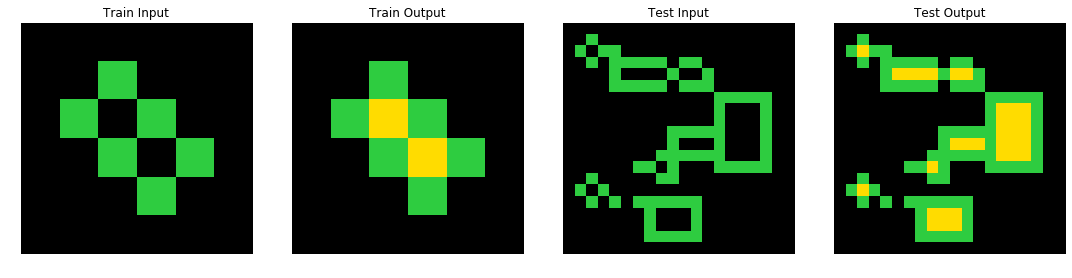

In [133]:
plot_task(task)

# Using the correct prediction format

In [134]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


The `output_id` is the `id` of the task, followed by the index of the `test` input that you should use to make your prediction. The `output` is the predicted output of the corresponding `test` input, reformatted into a string representation. (You can make three predictions per `output_id`, delineated by a space.) Use the following function to convert from a 2d python list to the string representation.

In [135]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [136]:
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

|123|456|789|


# Re-creating the sample submission output

This demonstrates how to loop over the sample submission and make predictions.

In [137]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    # skipping over the training examples, since this will be naive predictions
    # we will use the test input grid as the base, and make some modifications
    data = task['test'][pair_id]['input'] # test pair input
    # for the first guess, predict that output is unchanged
    pred_1 = flattener(data)
    # for the second guess, change all 0s to 5s
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    # for the last gues, change everything to 0
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    # concatenate and add to the submission output
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')

# Raphaels Start

Read all tasks, and check if they are complete (should be 400)

I removed 11 cases where there are more than 5 task demonstrations.


## Data processing

I want to have a model with 12 inputs.

1. created features/meta data
2. Input task demonstration 1
3. Output task demonstration 1
2. Input task demonstration 2
3. Output task demonstration 2
2. Input task demonstration 3 (or 30x30 of 10's)
3. Output task demonstration 3 (or 30x30 of 10's)
2. Input task demonstration 4 (or 30x30 of 10's)
3. Output task demonstration 4 (or 30x30 of 10's)
2. Input task demonstration 5 (or 30x30 of 10's)
3. Output task demonstration 5 (or 30x30 of 10's)
2. Input task test

Therefore I'll create the corresponding data out of the task list.


### DONE:
- creating 2-12

> ### TODO:
- create 1
- handle 11 cases where there are more than 5 task demonstrations in `train`
- handle cases where there are more than 1 (input, output) tuples in `test`


In [138]:
def get_task_list(tasks):
    train_task_list = []

    for task_name in training_tasks:
        task_file = str(training_path / task_name)

        with open(task_file, 'r') as f:
            task = json.load(f)
            if len(task['train']) < 6:
                train_task_list.append(task)
    return train_task_list

In [ ]:
# function for enhancing array size to 30 x 30
def enhance_mat_30x30(mat):
    empty_array = np.full((30, 30), 10, dtype=np.float32)
    if(len(mat) != 0):
        mat = np.asarray(mat, dtype=np.float32)
        empty_array[:mat.shape[0], : mat.shape[1]] = mat
        
    return np.expand_dims(empty_array, axis= 2) 

In [ ]:
train_task_list = get_task_list(training_tasks)
tasko = train_task_list[0]

In [ ]:
enhance_mat_30x30(tasko['train'][0]['input']).shape

In [ ]:
len(train_task_list)

In [ ]:
def create_11_list_data_and_output(task_list):    
    all_in = [[] for i in range(11)]
    target = []
    
    left_cnt = 0 # how many empty arrays to add
    
    for task in task_list:
        left_cnt = 5 - len(task['train'])
        
        # test input and output
        all_in[10].append(enhance_mat_30x30(task['test'][0]['input']))
        target.append(enhance_mat_30x30(task['test'][0]['output']))
        
        # train - multiple input and output
        # ATTENTION: won't work if there are more than 5 task demonstrations
        # ATTENTION: won't read more than 1 input-output pair in tests
        for idx, task_demonstration in enumerate(task['train']):
            all_in[(idx * 2)].append(enhance_mat_30x30(task_demonstration['input']))
            all_in[(idx * 2) + 1].append(enhance_mat_30x30(task_demonstration['output']))
            
        if left_cnt > 0:
            all_in[8].append(enhance_mat_30x30([]))
            all_in[9].append(enhance_mat_30x30([]))
        if left_cnt > 1:
            all_in[6].append(enhance_mat_30x30([]))
            all_in[7].append(enhance_mat_30x30([]))
        if left_cnt > 2:
            all_in[4].append(enhance_mat_30x30([]))
            all_in[5].append(enhance_mat_30x30([]))

    return all_in, target
        
    


In [ ]:
X_all, y = create_11_list_data_and_output(train_task_list)

In [ ]:
X_all[0]

In [ ]:


print(len(y))
y

In [ ]:
# verify data
print('Train: ')
for el in X_all:
    print(len(el))
    
print('Test: ')
print(len(y))

## Time to setup a model
As mentioned before, I'd like to setup a multi input model.

To create this I'll use the `Functional API of KERAS`. 

In [1]:
# imports

from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.models import Model

from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

import numpy as np
np.random.seed(0)  # Set a random seed for reproducibility

ModuleNotFoundError: No module named 'keras'

In [ ]:
#model.fit(inputs=[all_in[0], all_in[1], all_in[2],])

In [ ]:
def create_model():
    input_0 = Input(shape=(30, 30, 1,), dtype='float32', name='input_0')
    output_0 = Input(shape=(30, 30, 1,), dtype='float32', name='output_0')
    input_1 = Input(shape=(30, 30, 1,), dtype='float32', name='input_1')
    output_1 = Input(shape=(30, 30, 1,), dtype='float32', name='output_1')
    input_2 = Input(shape=(30, 30, 1,), dtype='float32', name='input_2')
    output_2 = Input(shape=(30, 30, 1,), dtype='float32', name='output_2')
    input_3 = Input(shape=(30, 30, 1,), dtype='float32', name='input_3')
    output_3 = Input(shape=(30, 30, 1,), dtype='float32', name='output_3')
    input_4 = Input(shape=(30, 30, 1,), dtype='float32', name='input_4')
    output_4 = Input(shape=(30, 30, 1,), dtype='float32', name='output_4')
    
    input_test = Input(shape=(30, 30, 1,), dtype='float32', name='input_test')
    
    
    x = Conv2D(32, kernel_size=(3,3))(input_0)
    batch_input_0 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(output_0)
    batch_output_0 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_1)
    batch_input_1 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_1)
    batch_output_1 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_2)
    batch_input_2 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_2)
    batch_output_2 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_3)
    batch_input_3 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_3)
    batch_output_3 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_4)
    batch_input_4 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_4)
    batch_output_4 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_test)
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_test = BatchNormalization()(x)
    
    
    x = concatenate([batch_input_0, batch_output_0])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_0 = BatchNormalization()(x)
    
    x = concatenate([batch_input_1, batch_output_1])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_1 = BatchNormalization()(x)
    
    x = concatenate([batch_input_2, batch_output_2])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_2 = BatchNormalization()(x)
    
    x = concatenate([batch_input_3, batch_output_3])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_3 = BatchNormalization()(x)
    
    x = concatenate([batch_input_4, batch_output_4])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_4 = BatchNormalization()(x)
    
    
    x = concatenate([batch_0, batch_1, batch_2, batch_3, batch_4, batch_test])
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(11, name='output')(x)
    
    
    model = Model(inputs=[input_0, output_0, input_1, output_1, input_2, output_2, input_3, output_3, input_4, output_4, input_test], outputs=[output])
    
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
    return model

In [ ]:
def create_classification_model():
    input_0 = Input(shape=(30, 30, 1,), dtype='float32', name='input_0')
    output_0 = Input(shape=(30, 30, 1,), dtype='float32', name='output_0')
    input_1 = Input(shape=(30, 30, 1,), dtype='float32', name='input_1')
    output_1 = Input(shape=(30, 30, 1,), dtype='float32', name='output_1')
    input_2 = Input(shape=(30, 30, 1,), dtype='float32', name='input_2')
    output_2 = Input(shape=(30, 30, 1,), dtype='float32', name='output_2')
    input_3 = Input(shape=(30, 30, 1,), dtype='float32', name='input_3')
    output_3 = Input(shape=(30, 30, 1,), dtype='float32', name='output_3')
    input_4 = Input(shape=(30, 30, 1,), dtype='float32', name='input_4')
    output_4 = Input(shape=(30, 30, 1,), dtype='float32', name='output_4')
    
    input_test = Input(shape=(30, 30, 1,), dtype='float32', name='input_test')
    
    
    x = Conv2D(32, kernel_size=(3,3))(input_0)
    batch_input_0 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(output_0)
    batch_output_0 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_1)
    batch_input_1 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_1)
    batch_output_1 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_2)
    batch_input_2 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_2)
    batch_output_2 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_3)
    batch_input_3 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_3)
    batch_output_3 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_4)
    batch_input_4 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_4)
    batch_output_4 = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(3,3))(input_test)
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_test = BatchNormalization()(x)
    
    
    x = concatenate([batch_input_0, batch_output_0])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_0 = BatchNormalization()(x)
    
    x = concatenate([batch_input_1, batch_output_1])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_1 = BatchNormalization()(x)
    
    x = concatenate([batch_input_2, batch_output_2])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_2 = BatchNormalization()(x)
    
    x = concatenate([batch_input_3, batch_output_3])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_3 = BatchNormalization()(x)
    
    x = concatenate([batch_input_4, batch_output_4])
    x = Conv2D(32, kernel_size=(3,3))(x)
    batch_4 = BatchNormalization()(x)
    
    
    x = concatenate([batch_0, batch_1, batch_2, batch_3, batch_4, batch_test])
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    
    outputs = []
    
    for i in range(900):
        outputs.append(Dense(11, activation='softmax', name=str('ouput_' + str(i)))(x))
    
    model = Model(inputs=[input_0, output_0, input_1, output_1, input_2, output_2, input_3, output_3, input_4, output_4, input_test], outputs=outputs)
    
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss="categorical_crossentropy", optimizer=opt)
    return model

In [ ]:
cla_model = create_classification_model()

In [ ]:
cla_model.summary()

In [ ]:
model = create_model()

In [ ]:
model.summary()

In [ ]:
#np.array(X_all).

In [ ]:
#np.array(y_new).reshape([389, 11])

In [ ]:
history = cla_model.fit([X_all[0], X_all[1], X_all[2], X_all[3], X_all[4], X_all[5], X_all[6], X_all[7], X_all[8], X_all[9], X_all[10]],
          [el for el in to_categorical(np.swapaxes(y_new,0,1))],
         epochs=100)

In [ ]:
cla_model.save(output_path / 'ourweights_class_900_outs.h5')

In [ ]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [ ]:
#y_new = to_categorical(y, num_classes=11)
np.array(y).reshape(900, 386)

In [ ]:
y_new = np.array(y).reshape(389, 900)

In [ ]:
np.swapaxes(y_new,0,1).shape


In [ ]:
to_categorical(np.swapaxes(y_new,0,1)).shape

In [ ]:
history.history['loss']

In [ ]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])

In [ ]:
preds = cla_model.predict([X_all[0], X_all[1], X_all[2], X_all[3], X_all[4], X_all[5], X_all[6], X_all[7], X_all[8], X_all[9], X_all[10]])

In [ ]:
preds[0].reshape([30, 30])[:3, :3]

In [ ]:
first_pred_post = np.array([np.argmax(preds[i][0]) for i in range(len(preds))]).reshape([30, 30])

In [ ]:
plot_matrix(first_pred_post)

In [ ]:
plot_matrix(train_task_list[0]['test'][0]['output'])

# FLORIANS Start

## Multi Input - somewhat reinforcement learning

3 inputs
1. all train input samples in one array
2. all train output samples in one array
2. the test input
3. the past predictions for this task

2 output
1. single pixel - value 0-9
2. the predicted size of the task


SUDO CODE TRAINING: 

1. get perfect samples for every pixel
2. predict every sample pixel 100.000x (e-greedy: first random then with model)
3. get discounted rewards for every prediction - (1 point for completed column, 1 point for completed row, 1 point for right pixel value)
4. train network on all collected samples
5. iterate over 2-4 until convergence ;)

In [139]:
train_data = get_task_list(training_tasks)

In [ ]:
train_data[0]

In [140]:
def preprocess_task(task):
    input_1 = [] # all training inputs flattened and concatenated
    input_2 = [] # all training outputs flattened and concatenated
    input_3 = [] # all test inputs 
    input_4 = None # Initially None, will be filled with predicted values over time
    for sample in task['train']:
        input_1 = np.append(input_1, sample['input'])
        input_2 = np.append(input_2, sample['output'])
    for sample in task['test']:
        input_3 = np.append(input_3, sample['input'])
    return input_1, input_2, input_3, input_4

input_list_1, input_list_2, input_list_3, input_list_4 = [], [], [], []
for task in train_data:
    input_1, input_2, input_3, input_4 = preprocess_task(task)
    input_list_1.append(input_1)
    input_list_2.append(input_2)
    input_list_3.append(input_3)
    input_list_4.append(input_4)
input_list_3[0]

array([7., 0., 7., 7., 0., 7., 7., 7., 0.])

In [ ]:
type(input_list_3[0])

In [ ]:
train_data[0]['test'][0]['output']

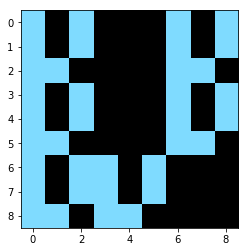

In [141]:
plot_matrix(train_data[0]['test'][0]['output'])

In [142]:
output_shape = []
for task in train_data:
    rows = len(task['test'][0]['output'])
    cols = len(task['test'][0]['output'][0])
    output_shape.append(np.array([rows, cols]))
output_shape = np.array(output_shape)
iterations_per_task = [np.prod(task) for task in output_shape]
output_shape

array([[ 9,  9],
       [20, 20],
       [ 9,  3],
       [10, 10],
       [21, 21],
       [ 3,  3],
       [ 7,  7],
       [11, 10],
       [26, 26],
       [ 9,  9],
       [11, 11],
       [12, 12],
       [11, 27],
       [ 6,  6],
       [ 9,  9],
       [ 3,  3],
       [21, 21],
       [24, 19],
       [12, 10],
       [10, 10],
       [ 5,  3],
       [ 3,  3],
       [ 8, 11],
       [12, 11],
       [19, 26],
       [ 5,  3],
       [10, 10],
       [10, 10],
       [ 8,  9],
       [10, 10],
       [ 4,  6],
       [ 5,  5],
       [17, 17],
       [ 9,  9],
       [10, 10],
       [ 4,  4],
       [10, 10],
       [ 1,  5],
       [ 3,  3],
       [10, 10],
       [10, 10],
       [10, 10],
       [10, 10],
       [10, 10],
       [10, 10],
       [ 3,  8],
       [ 9,  9],
       [ 3,  3],
       [16, 11],
       [ 3,  3],
       [ 3,  3],
       [30, 30],
       [17, 15],
       [ 3,  6],
       [18, 18],
       [11, 11],
       [ 5, 11],
       [18, 18],
       [10, 10

In [152]:
output_pixel_all_iterations = []
for task in train_data:
    full_output = np.array(task['test'][0]['output']).flatten()
    all_iters_task = []
    for i in range(len(full_output)): # number of iterations = number of pixels in test ouput
        pixel = full_output[i]
        pixel_dummies = np.array([pixel == i for i in range(0, 11)])
        all_iters_task.append(pixel_dummies)
    output_pixel_all_iterations.append(all_iters_task)
output_pixel_all_iterations[0]

[array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, 

In [151]:
output_pixel_all_iterations

[array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, False, False, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([False, False, False, False, False, False, False,  True, False,
        False, False]),
 array([ True, False, False, False, False, False, 

In [ ]:
# preprocess output

pd.get_dummies(range(0,11))

output_pixel, output_shape = [], [] 
for sample in task['test']:
    output_pixel = np.append(output_1, sample['output'])

In [ ]:
input_1.shape # could hopefully be any shape

In [ ]:
from keras.layers import Input, Dense, Flatten, Conv1D, concatenate, Subtract
from keras.models import Model

def create_model():
    input_1 = Input(shape=(None, 1,), dtype='float32', name='input_1')
    input_2 = Input(shape=(None, 1,), dtype='float32', name='input_2')
    input_3 = Input(shape=(None, 1,), dtype='float32', name='input_3')
    input_4 = Input(shape=(None, 1), dtype='float32', name='input_4')

    x_1 = Conv1D(32, kernel_size=(2))(input_1)
    x_2 = Conv1D(32, kernel_size=(2))(input_2)
    x_sub = Subtract()([x_1, x_2])
    x_fin = Conv1D(32, kernel_size=(2))(x_sub)
    
    y_1 = Conv1D(32, kernel_size=(2))(input_3)
    y_2 = Conv1D(32, kernel_size=(2))(input_4)
    y_con = concatenate([y_1, y_2])
    y_fin = Conv1D(32, kernel_size=(2))(y_con)
    
    merge = concatenate([x_fin, y_fin])
    
    out_1 = Dense(11, activation='relu')(merge)
    out_1 = Dense(128, activation='relu')(out_1)
    out_1 = Dense(256, activation='relu')(out_1)
    out_1 = Dense(512, activation='relu')(out_1)
    out_1 = Dense(11, activation='softmax', name='pixel_predictor')(out_1)

    out_2 = Dense(64, activation='relu')(merge)
    out_2 = Dense(2, activation='linear', name='shape_predictor')(out_2)
    
    model = Model(inputs=[input_1, input_2, input_3, input_4], outputs=[out_1, out_2])
    
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    losses = {
        "pixel_predictor": "categorical_crossentropy",
        "shape_predictor": "mean_absolute_error",
    }

    model.compile(loss=losses, optimizer=opt)
    return model

multi_cnn = create_model()

In [ ]:
multi_cnn.summary()

In [ ]:
history = multi_cnn.fit(x = [input_list_1, input_list_2, input_list_3, input_list_4],
                        y = [output_list_1, output_list_2]
         epochs=10)